## American Football Network
#### The network is about American football games between Division IA colleges during regular season Fall 2000, as compiled by Girvan and Newman. The dataset consists of 115 nodes representing football teams (labeled by their college names) and 613 edges are placed representing regular-season games between the two teams. The dataset we used is an updated version with erroneously duplicated edges been removed.  The nodes have values that indicate to which conferences they belong.  The values are as follows:
#####  0 = Atlantic Coast, 1 = Big East, 2 = Big Ten, 3 = Big Twelve, 4 = Conference USA, 5 = Independents, 6 = Mid-American, 7 = Mountain West, 8 = Pacific Ten, 9 = Southeastern, 10 = Sun Belt, 11 = Western Athletic

In [5]:
import community
import networkx as nx
import matplotlib.pyplot as plt

# read football network data in gml format
fb = nx.read_gml("/Users/kate/football.gml", label = 'id' )

## 1. Apply Girvan-Newman algorithm 

In [3]:
import networkx as nx

__all__ = ['girvan_newman']


def girvan_newman(G, most_valuable_edge=None):
    """Finds communities in a graph using the Girvan–Newman method.

    Parameters
    ----------
    G : NetworkX graph

    most_valuable_edge : function
        Function that takes a graph as input and outputs an edge. The
        edge returned by this function will be recomputed and removed at
        each iteration of the algorithm.

        If not specified, the edge with the highest
        :func:`networkx.edge_betweenness_centrality` will be used.

    Returns
    -------
    iterator
        Iterator over tuples of sets of nodes in `G`. Each set of node
        is a community, each tuple is a sequence of communities at a
        particular level of the algorithm.

    Examples
    --------
    To get the first pair of communities::

        >>> G = nx.path_graph(10)
        >>> comp = girvan_newman(G)
        >>> tuple(sorted(c) for c in next(comp))
        ([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

    To get only the first *k* tuples of communities, use
    :func:`itertools.islice`::

        >>> import itertools
        >>> G = nx.path_graph(8)
        >>> k = 2
        >>> comp = girvan_newman(G)
        >>> for communities in itertools.islice(comp, k):
        ...     print(tuple(sorted(c) for c in communities)) # doctest: +SKIP
        ...
        ([0, 1, 2, 3], [4, 5, 6, 7])
        ([0, 1], [2, 3], [4, 5, 6, 7])

    To stop getting tuples of communities once the number of communities
    is greater than *k*, use :func:`itertools.takewhile`::

        >>> import itertools
        >>> G = nx.path_graph(8)
        >>> k = 4
        >>> comp = girvan_newman(G)
        >>> limited = itertools.takewhile(lambda c: len(c) <= k, comp)
        >>> for communities in limited:
        ...     print(tuple(sorted(c) for c in communities)) # doctest: +SKIP
        ...
        ([0, 1, 2, 3], [4, 5, 6, 7])
        ([0, 1], [2, 3], [4, 5, 6, 7])
        ([0, 1], [2, 3], [4, 5], [6, 7])

    To just choose an edge to remove based on the weight::

        >>> from operator import itemgetter
        >>> G = nx.path_graph(10)
        >>> edges = G.edges()
        >>> nx.set_edge_attributes(G, {(u, v): v for u, v in edges}, 'weight')
        >>> def heaviest(G):
        ...     u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
        ...     return (u, v)
        ...
        >>> comp = girvan_newman(G, most_valuable_edge=heaviest)
        >>> tuple(sorted(c) for c in next(comp))
        ([0, 1, 2, 3, 4, 5, 6, 7, 8], [9])

    To utilize edge weights when choosing an edge with, for example, the
    highest betweenness centrality::

        >>> from networkx import edge_betweenness_centrality as betweenness
        >>> def most_central_edge(G):
        ...     centrality = betweenness(G, weight='weight')
        ...     return max(centrality, key=centrality.get)
        ...
        >>> G = nx.path_graph(10)
        >>> comp = girvan_newman(G, most_valuable_edge=most_central_edge)
        >>> tuple(sorted(c) for c in next(comp))
        ([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

    To specify a different ranking algorithm for edges, use the
    `most_valuable_edge` keyword argument::

        >>> from networkx import edge_betweenness_centrality
        >>> from random import random
        >>> def most_central_edge(G):
        ...     centrality = edge_betweenness_centrality(G)
        ...     max_cent = max(centrality.values())
        ...     # Scale the centrality values so they are between 0 and 1,
        ...     # and add some random noise.
        ...     centrality = {e: c / max_cent for e, c in centrality.items()}
        ...     # Add some random noise.
        ...     centrality = {e: c + random() for e, c in centrality.items()}
        ...     return max(centrality, key=centrality.get)
        ...
        >>> G = nx.path_graph(10)
        >>> comp = girvan_newman(G, most_valuable_edge=most_central_edge)

    Notes
    -----
    The Girvan–Newman algorithm detects communities by progressively
    removing edges from the original graph. The algorithm removes the
    "most valuable" edge, traditionally the edge with the highest
    betweenness centrality, at each step. As the graph breaks down into
    pieces, the tightly knit community structure is exposed and the
    result can be depicted as a dendrogram.

    """
    # If the graph is already empty, simply return its connected
    # components.
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # If no function is provided for computing the most valuable edge,
    # use the edge betweenness centrality.
    if most_valuable_edge is None:
        def most_valuable_edge(G):
            """Returns the edge with the highest betweenness centrality
            in the graph `G`.

            """
            # We have guaranteed that the graph is non-empty, so this
            # dictionary will never be empty.
            betweenness = nx.edge_betweenness_centrality(G)
            return max(betweenness, key=betweenness.get)
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    # Self-loops must be removed because their removal has no effect on
    # the connected components of the graph.
    g.remove_edges_from(nx.selfloop_edges(g))
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge)



def _without_most_central_edges(G, most_valuable_edge):
    """Returns the connected components of the graph that results from
    repeatedly removing the most "valuable" edge in the graph.

    `G` must be a non-empty graph. This function modifies the graph `G`
    in-place; that is, it removes edges on the graph `G`.

    `most_valuable_edge` is a function that takes the graph `G` as input
    (or a subgraph with one or more edges of `G` removed) and returns an
    edge. That edge will be removed and this process will be repeated
    until the number of connected components in the graph increases.

    """
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(G)
        G.remove_edge(*edge)
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
    return new_components

In [4]:
import timeit
start_time = timeit.default_timer()


#To get only the first 5 tuples of communitie
import itertools
k = 11
comp = girvan_newman(fb)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))

elapsed = timeit.default_timer() - start_time

([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 21, 22, 23, 24, 28, 32, 39, 40, 41, 46, 47, 49, 50, 51, 52, 53, 60, 64, 67, 68, 69, 72, 73, 74, 77, 78, 81, 82, 83, 84, 88, 90, 93, 98, 100, 102, 104, 106, 107, 108, 110, 111, 114], [1, 12, 14, 17, 18, 19, 20, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 48, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 70, 71, 75, 76, 79, 80, 85, 86, 87, 89, 91, 92, 94, 95, 96, 97, 99, 101, 103, 105, 109, 112, 113])
([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 21, 22, 23, 24, 28, 32, 39, 40, 41, 46, 47, 49, 50, 51, 52, 53, 60, 64, 67, 68, 69, 72, 73, 74, 77, 78, 81, 82, 83, 84, 88, 90, 93, 98, 100, 102, 104, 106, 107, 108, 110, 111, 114], [1, 17, 19, 20, 25, 27, 29, 30, 33, 35, 37, 44, 45, 48, 55, 56, 57, 58, 59, 62, 63, 65, 66, 70, 75, 76, 79, 80, 86, 87, 89, 91, 92, 94, 95, 96, 97, 101, 103, 105, 109, 112, 113], [12, 14, 18, 26, 31, 34, 36, 38, 42, 43, 54, 61, 71, 85, 99])
([0, 3, 4, 5, 7, 8, 9, 10, 11, 16, 21, 22, 23, 24, 28, 40,

In [5]:
#running time of GN algorithm
elapsed

7.759350648000009

### It can be seen that, if we want to extract 12 communities by GN algorithm, the most of  the nodes can be recoveryed correctly with the conference belonging. It is worth mentioning that there is a group which is a mix of members from "10" and "11" conferences. And there are 10 members are misclassified.

In [7]:
#plot the result of GN algorithm
partitiongn = {0:0, 1:1, 2:2, 3:3, 4:0, 5:3, 6:2, 7:4, 8:4, 9:0, 10:3, 11:5, 12:6, 13:2, 14:6, 15:2, 16:0,  17:7, 
               18:6, 19:8, 20:7, 21:4, 22:4, 23:0, 24:5, 25:1, 26:6, 27:7, 28:5, 29:8, 30:8, 31:6, 32:2, 33:1, 34:6, 
               35:8, 36:6, 37:1, 38:6, 39:2, 40:3, 41:0, 42:6, 43:6, 44:9, 45:1, 46:10, 47:2, 48:9, 49:10, 50:5, 
               51:4, 52:3, 53:10, 54:6, 55:8, 56:7, 57:9, 58:11, 59:11, 60:2, 61:6, 62:7, 63:11, 64:2, 66:9, 67:10, 
               68:4, 69:5, 70:7, 71:6, 72:3, 73:10, 74:3, 75:9, 76:7, 77:4, 78:4, 79:8, 80:8, 81:3, 82:3, 83:10, 84:3, 
               85:6, 86:9, 87:7, 88:10, 65:7, 89:1, 90:5, 91:9, 92:9, 93:0, 94:8, 95:7, 96:7, 97:11, 98:3,99:6,100:2, 
               101:8, 102:3, 103:1, 104:0, 105:1, 106:2, 107:3, 108:4, 109:1, 110:10, 111:4, 112:9, 113:7, 114:10}

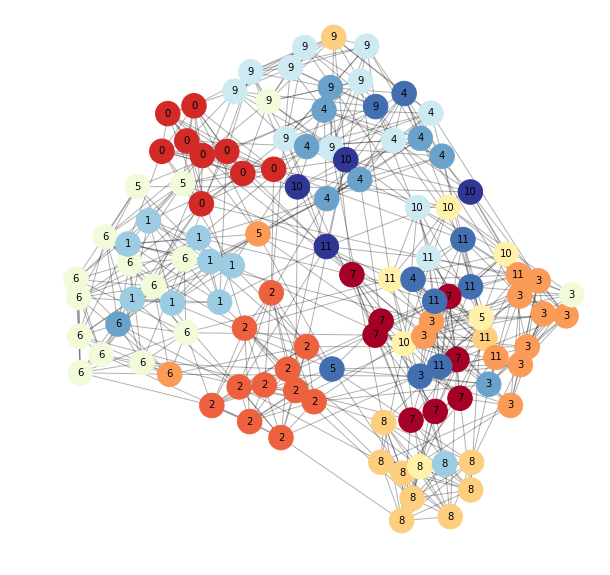

In [12]:
#import community
node_dict2 = fb.node 
newlabels2 = dict((x,node_dict2[x]['value']) for x in fb.nodes())


partition2 = partitiongn
pos = nx.spring_layout(fb)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(fb, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition2.values()))
nx.draw_networkx_edges(fb, pos, alpha=0.3)
nx.draw_networkx_labels(fb,pos,newlabels2,font_size=10,font_color='black')
plt.savefig("D_FootballGN.png", format="PNG")
plt.show(fb)

## 2. Apply Louvain method

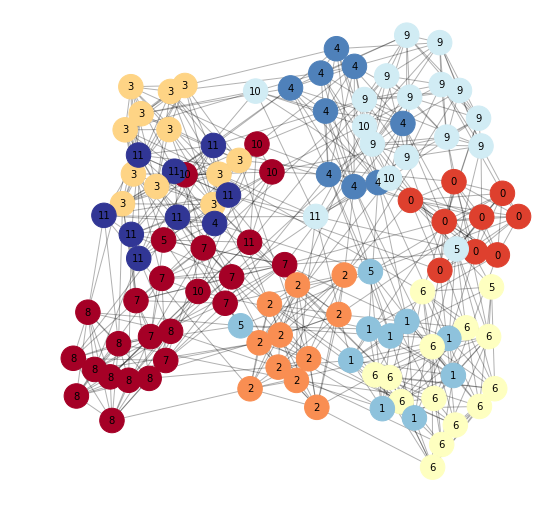

In [23]:
import timeit
start_time = timeit.default_timer()

import community
fb = nx.read_gml("/Users/kate/football.gml", label = 'id' )

node_dict2 = fb.node 
newlabels2 = dict((x,node_dict2[x]['value']) for x in fb.nodes())


partition2 = community.best_partition(fb)

elapsed = timeit.default_timer() - start_time

pos = nx.spring_layout(fb)
plt.figure(figsize=(9, 9))
plt.axis('off')
nx.draw_networkx_nodes(fb, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition2.values()))
nx.draw_networkx_edges(fb, pos, alpha=0.3)
nx.draw_networkx_labels(fb,pos,newlabels2,font_size=10,font_color='black')
#plt.savefig("D-FootballLouvain.png", format="PNG")
plt.show(fb)

In [24]:
#running time of Louvain
elapsed

0.138351565999983

In [ ]:
#pyitlib can help draw measures, if you dont' have, 
#you should install first use "pip install pyitlib"

In [13]:
#calculate the variation of information
import numpy as np
from pyitlib import discrete_random_variable as drv

In [9]:
arraygn= (0,1,2,3,0,3,2,4,4,0,3,5,6,2,6,2,0,7,6,8,7,4,4,0,5,1,6,7,5,8,8,6,2,1,6,8,6,1,6,2,3,0,6,6,9,1,
          10,2,9,10,5,4,3,10,6,8,7,9,11,11,2,6,7,11,2,9,10,4,5,7,6,3,10,3,9,7,4,4,8,8,3,3,10,3,6,9,7,
          10,7,1,5,9,9,0,8,7,7,11,3,6,2,8,3,1,0,1,2,3,4,1,10,4,9,7,10)

#arraygn2=(7,0,2,3,7,3,2,8,8,7,3,10,6,2,6,2,7,9,6,1,9,8,8,7,10,0,6,9,10,1,1,6,2,0,6,1,6,0,6,2,3,7,6,6,4,0,
#          11,2,4,11,10,8,3,11,6,1,9,4,10,10,2,6,9,10,2,4,11,8,10,9,6,3,11,3,4,9,8,8,1,1,3,3,11,3,6,4,
#          9,11,9,0,10,4,4,7,1,9,9,10,3,6,2,1,3,0,7,0,2,3,8,0,11,8,4,9,11)

arraymetadata=(7,0,2,3,7,3,2,8,8,7,3,10,6,2,6,2,7,9,6,1,9,8,8,7,10,0,6,9,11,1,
 1,6,2,0,6,1,5,0,6,2,3,7,5,6,4,0,11,2,4,11,10,8,3,11,6,1,9,4,11,
 10,2,6,9,10,2,9,4,11,8,10,9,6,3,11,3,4,9,8,8,1,5,3,5,11,3,6,4,
 9,11,0,5,4,4,7,1,9,9,10,3,6,2,1,3,0,7,0,2,3,8,0,4,8,4,9,11)

arraylouvain= (0,1,2,3,0,3,2,4,4,0,3,5,6,2,6,2,0,7,6,8,7,4,4,0,5,1,6,7,5,8,8,
 6,2,1,6,8,7,1,6,2,3,0,6,6,9,1,0,2,9,0,5,4,3,0,6,8,7,9,7,7,2,6,
 7,7,2,7,9,0,4,5,7,6,3,0,3,9,7,4,4,8,8,3,8,0,3,6,9,7,0,1,5,9,9,
 0,8,7,7,7,3,6,2,8,3,1,0,1,2,3,4,1,0,4,9,7,0)

In [21]:
print("VI between GN and metadata:", drv.information_variation(arraygn, arraymetadata, cartesian_product=False, base=2, fill_value=-1, estimator='ML', Alphabet_X=None, Alphabet_Y=None, keep_dims=False))
print("VI between Louvain and metadata:", drv.information_variation(arraylouvain, arraymetadata, cartesian_product=False, base=2, fill_value=-1, estimator='ML', Alphabet_X=None, Alphabet_Y=None, keep_dims=False))

VI between GN and metadata: 1.9296016934441034
VI between Louvain and metadata: 0.8134007124287819


### Comparison of GN and Louvain:

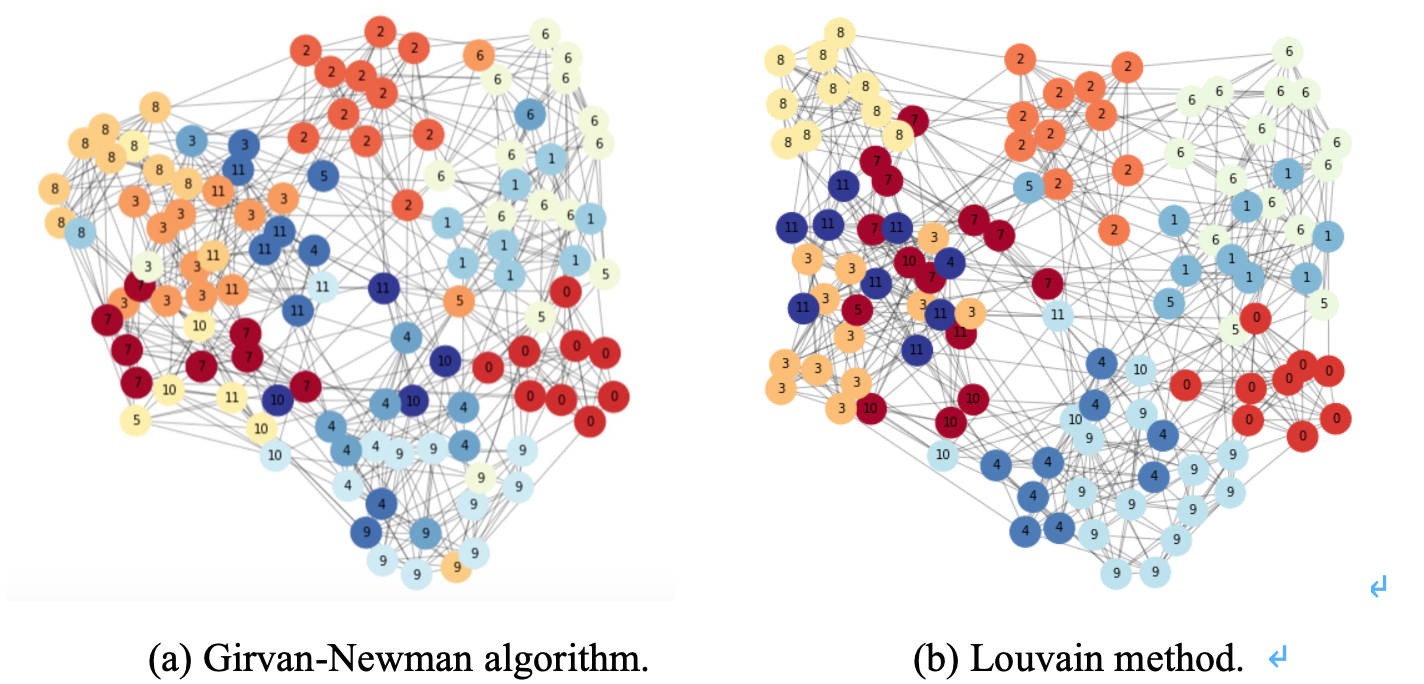

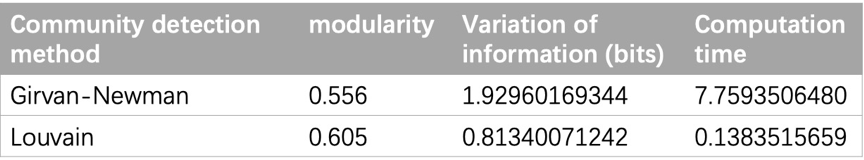

### By comparison, it can be verified that Girvan-Newman algorithm loses its effcient on complex networks though it performs well on simple small size networks. Comparatively, the Louvain method becomes popular on large size complex networks not only for its satisfying accuracy and rationality on community detection, but also for its superiority on computation time.

## 3. Try Stochastic Block Model fit to infer communities
##### more can go to "D-American Football SBM. jpynb" and the package "graph-tool" is required

### Stochastic block model (SBM) is a generative model, the reverse of the generation process, i.e. the fitting of SBM, is the main concern of this project, through which one can incorporate node metadata into community detection problem.
### Firstly, we sampling from posterior distribution

In [1]:
#import packages and read network data
import graph_tool.all as gt
from graph_tool.all import *
from matplotlib import pyplot as plt
import timeit
import numpy as np

g = gt.collection.data["football"]

In [2]:
#visualization (with spring layout)
graph_tool.draw.sfdp_layout(g,mu =1000.0)

#to obtain group information
g.list_properties()      

description    (graph)   (type: string, val: American College football: network
                                             of American football games between
                                             Division IA colleges during regular
                                             season Fall 2000. Please cite M.
                                             Girvan and M. E. J. Newman, Proc.
                                             Natl. Acad. Sci. USA 99, 7821-7826
                                             (2002). Retrieved from `Mark
                                             Newman's website <http://www-person
                                             al.umich.edu/~mejn/netdata/>`_.
                                             This file also contains corrections
                                             made by T. S. Evans, available
                                             `here <http://figshare.com/articles
                                             /Americ

In [3]:
#fit non degree-corrected nested SBM and degree-corrected nested sbm reperatively
##by maximizing the likelihood that an observed network A generated with partition b={b_i}, i.e., P(b|A).
#and calculate the entropy
state_ndc = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state_dc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)
print ("Non-degree-corrected DL:\t",state_ndc.entropy())   
print ("Degree-corrected DL:\t",state_dc.entropy())        



Non-degree-corrected DL:	 1733.525685145172
Degree-corrected DL:	 1796.3703055595713


In [4]:
#obtain information of NO. of clusters in each level of nested SBM fitting process
state_dc.print_summary()


l: 0, N: 115, B: 8
l: 1, N: 8, B: 2
l: 2, N: 2, B: 1


In [5]:
state_ndc.print_summary()


l: 0, N: 115, B: 10
l: 1, N: 10, B: 2
l: 2, N: 2, B: 1


In [6]:
#visualization
vvertex = g.vertex_properties["value"]

state_dc.draw(pos=sfdp_layout(g),  vertex_text=vvertex, vertex_font_size =30, output_size=(3000, 3000), output="dc.png")


(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x145a72c10, at 0x12aa59b50>,
 <Graph object, directed, with 126 vertices and 125 edges at 0x145c30d50>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x145c30d50, at 0x146b227d0>)

In [7]:
state_ndc.draw(pos=sfdp_layout(g),  vertex_text=vvertex, vertex_font_size =30, output_size=(3000, 3000), output="ndc.png")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x145a72c10, at 0x146b1d610>,
 <Graph object, directed, with 128 vertices and 127 edges at 0x145c20b50>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x145c20b50, at 0x145c208d0>)

In [8]:
#to obtain group information
levels_ndc = state_ndc.get_levels()  
for v in g.vertices():
    vindex = g.vertex_index[v]
    r = levels_ndc[0].get_blocks()[vindex]
    print (r)


0
1
2
3
0
3
2
4
4
0
3
0
5
2
5
2
0
6
5
7
6
4
4
0
0
1
5
6
0
7
7
5
2
1
5
7
5
1
5
2
3
0
5
5
9
1
8
2
9
8
0
4
3
8
5
7
6
9
9
9
2
5
6
9
2
6
9
8
4
0
6
5
3
8
3
9
6
4
4
7
7
3
7
8
3
5
9
6
8
1
0
9
9
0
7
6
6
9
3
5
2
7
3
1
0
1
2
3
4
1
8
4
9
6
8


In [9]:
#to obtain group information    
levels_dc = state_dc.get_levels() 
for v in g.vertices():
    vindex = g.vertex_index[v]
    r = levels_dc[0].get_blocks()[vindex]
    print (r)

0
1
2
3
0
3
2
0
0
0
3
0
4
2
4
2
0
5
4
6
5
0
0
0
0
1
4
5
0
6
6
4
2
1
4
6
4
1
4
2
3
0
4
4
7
1
3
2
7
3
0
0
3
3
4
6
5
7
7
7
2
4
5
7
2
5
7
3
0
0
5
4
3
3
3
7
5
0
0
6
6
3
6
3
3
4
7
5
3
1
0
7
7
0
6
5
5
7
3
4
2
6
3
1
0
1
2
3
0
1
3
0
7
5
3


#### Visualization of the nested SBM and DCSBM:
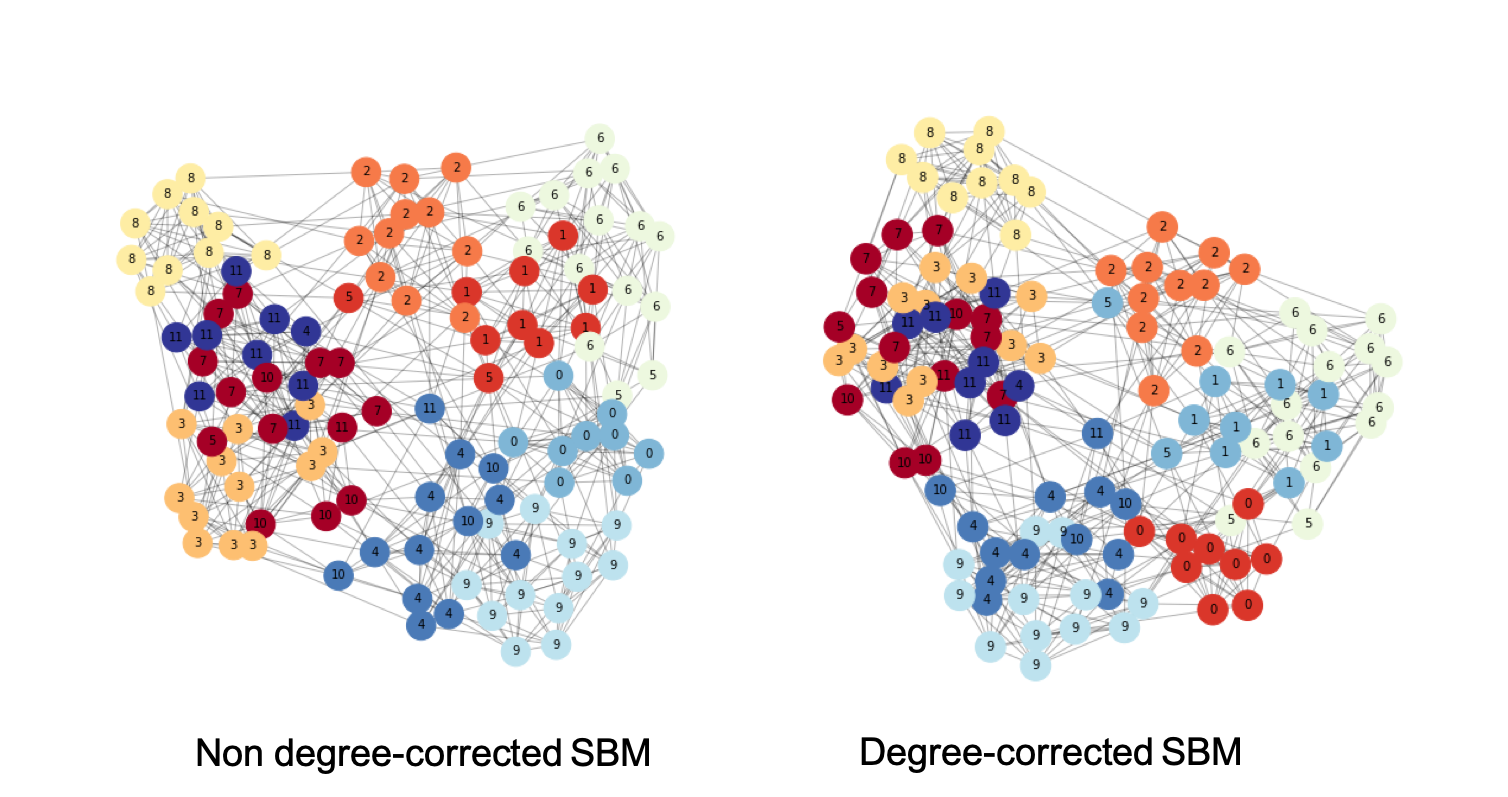

In [10]:
#summary the dected communities by the non degree-corrected nested SBM 
#and the non degree-corrected nested SBM

arraysbmdc=(0,1,2,3,0,3,2,4,4,0,3,0,5,2,5,2,0,6,5,7,6,4,4,0,0,1,5,6,0,7,7,5,2,1,5,7,5,1,5,2,3,0,5,5,8,1,9,2,8,9,0,4,3,
            9,5,7,6,8,8,8,2,5,6,8,2,6,8,9,4,0,6,5,3,9,3,8,6,4,4,7,7,3,7,9,3,5,8,6,9,1,0,8,8,0,7,6,6,8,3,5,2,7,3,
1,0,1,2,3,4,1,9,4,8,6,9)

arraysbmndc=(0,7,2,3,0,3,2,4,4,0,3,0,5,2,5,2,0,6,5,1,6,4,4,0,0,7,5,6,0,1,1,5,2,7,5,1,5,7,5,2,3,0,5,5,8,7,9,2,8,9,0,4,3,
             9,5,1,6,8,8,8,2,5,6,8,2,6,8,9,4,0,6,5,3,9,3,8,6,4,4,1,1,3,1,9,3,5,8,6,9,
7,0,8,8,0,1,6,6,8,3,5,2,1,3,7,0,7,2,3,4,7,9,4,8,6,9)

import numpy as np
from pyitlib import discrete_random_variable as drv

print("VI between the ndc SBM fit and ground truth:",drv.information_variation(arraysbmndc, arraymetadata, 
                                                                cartesian_product=False, base=2, fill_value=-1, estimator='ML', Alphabet_X=None, Alphabet_Y=None, keep_dims=False))

print("VI between the dc SBM fit and ground truth:",drv.information_variation(arraysbmdc, arraymetadata, 
                                                                              cartesian_product=False, base=2, fill_value=-1, estimator='ML', Alphabet_X=None, Alphabet_Y=None, keep_dims=False))


VI between the ndc SBM fit and ground truth: 0.7372712660964127
VI between the dc SBM fit and ground truth: 0.7372712660964127


In [ ]:
#calculate computation of the nested SBM
import timeit
start_time = timeit.default_timer()
state_ndc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
elapsed_ndc = timeit.default_timer() - start_time
elapsed_ndc

##average on 10 tims calculation: 10.351597044

In [ ]:
#calculate computation of the nested DCSBM
start_time = timeit.default_timer()
state_dc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)
elapsed_dc = timeit.default_timer() - start_time
elapsed_dc

##average on 10 tims calculation: 9.9283644330

#### It can be seen that the nested SBM fit resulted 10 communities while there are 12 in fact.

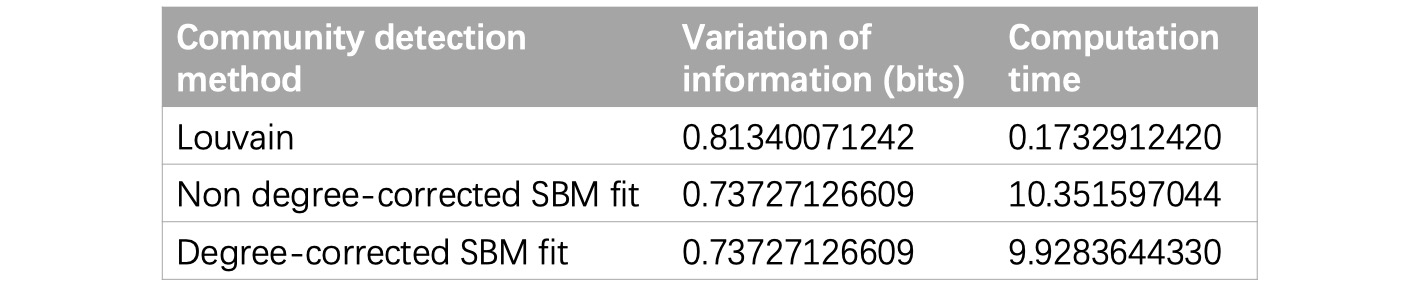
#### nested SBM can yield more accurate results for dcSBM and ndcSBM possesses same smaller value of VI. 
#### When it comes to the comparision of degree-corrected SBM and non degree-corrected SBM in this case, non degree-corrected SBM is the model we prefered as it has smaller entropy. Moreover, as for commutation time, degree-corrected SBM (9.9) is just a little faster than non degree-corrected SBM (10.35). In summary, the degree-corrected variant is an unnecessarily complex description for this network.

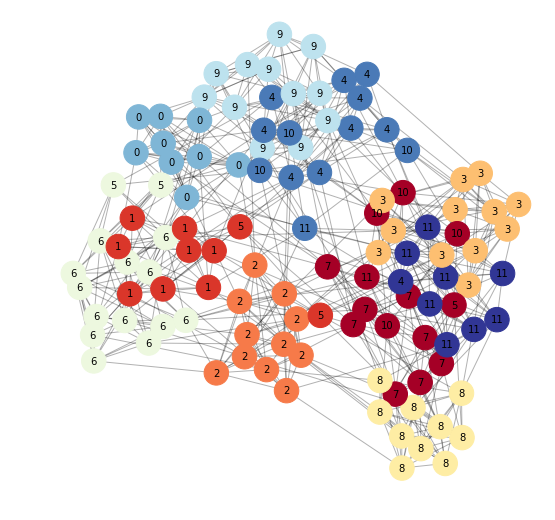

In [61]:
import community
fb = nx.read_gml("/Users/kate/football.gml", label = 'id' )
node_dict2 = fb.node 
newlabels2 = dict((x,node_dict2[x]['value']) for x in fb.nodes())


partition_sbmndc = {0:0,1:7,2:2,3:3,4:0,5:3,6:2,7:4,8:4,9:0,10:3,11:0,12:5,13:2,14:5,15:2,16:0,17:6,18:5,19:1,20:6,
                    21:4,22:4,23:0,24:0,25:7,26:5,27:6,28:0,29:1,30:1,31:5,32:2,33:7,34:5,35:1,36:5,37:7,38:5,39:2,
                    40:3,41:0,42:5,43:5,44:8,45:7,46:9,47:2,48:8,49:9,50:0,51:4,52:3,53:9,54:5,55:1,56:6,57:8,58:8,
                    59:8,60:2,61:5,62:6,63:8,64:2,65:6,66:8,67:9,68:4,69:0,70:6,71:5,72:3,73:9,74:3,75:8,76:6,77:4,
                    78:4,79:1,80:1,81:3,82:1,83:9,84:3,85:5,86:8,87:6,88:9,89:7,90:0,91:8,92:8,93:0,94:1,95:6,96:6,
                    97:8,98:3,99:5,100:2,101:1,102:3,103:7,104:0,105:7,106:2,107:3,108:4,109:7,110:9,111:4,112:8,
                    113:6,114:9}

pos = nx.spring_layout(fb)
plt.figure(figsize=(9, 9))
plt.axis('off')
nx.draw_networkx_nodes(fb, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition_sbmndc.values()))
nx.draw_networkx_edges(fb, pos, alpha=0.3)
nx.draw_networkx_labels(fb,pos,newlabels2,font_size=10,font_color='black')
plt.savefig("D-football-sbmndcc.png", format="PNG")
plt.show(fb)

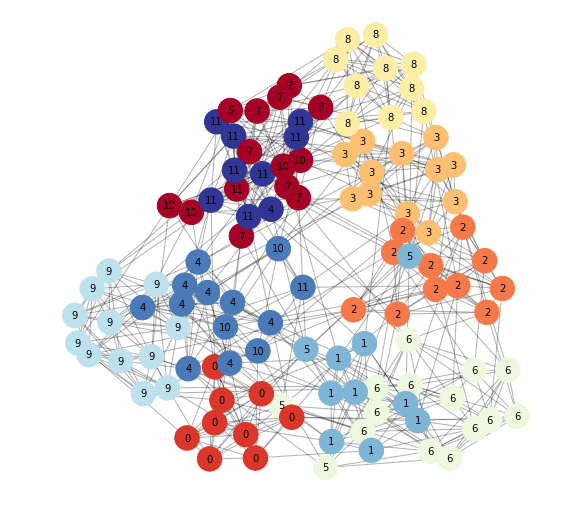

In [62]:
import community
fb = nx.read_gml("/Users/kate/football.gml", label = 'id' )
node_dict2 = fb.node 
newlabels2 = dict((x,node_dict2[x]['value']) for x in fb.nodes())


partition_sbmdc = {0:0,1:1,2:2,3:3,4:0,5:3,6:2,7:4,8:4,9:0,10:3,11:0,12:5,13:2,14:5,15:2,16:0,17:6,18:5,19:7,20:6,21:4,
                   22:4,23:0,24:0,25:1,26:5,27:6,28:0,29:7,30:7,31:5,32:2,33:1,34:5,35:7,36:5,37:1,38:5,39:2,40:3,41:0,
                   42:5,43:5,44:8,45:1,46:9,47:2,48:8,49:9,50:0,51:4,52:3,53:9,54:5,55:7,56:6,57:8,58:8,59:8,60:2,61:5,
                   62:6,63:8,64:2,65:6,66:8,67:9,68:4,69:0,70:6,71:5,72:3,73:9,74:3,75:8,76:6,77:4,78:4,79:7,80:7,81:3,
                   82:7,83:9,84:3,85:5,86:8,87:6,88:9,89:1,90:0,91:8,92:8,93:0,94:7,95:6,96:6,97:8,98:3,99:5,100:2,101:7,
                   102:3,103:1,104:0,105:1,106:2,107:3,108:4,109:1,110:9,111:4,112:8,113:6,114:9}


pos = nx.spring_layout(fb)
plt.figure(figsize=(9, 9))
plt.axis('off')
nx.draw_networkx_nodes(fb, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition_sbmdc.values()))
nx.draw_networkx_edges(fb, pos, alpha=0.3)
nx.draw_networkx_labels(fb,pos,newlabels2,font_size=10,font_color='black')
plt.savefig("D-football-sbmdc2.png", format="PNG")
plt.show(fb)

### From the performance of SBM on this football network, we get inspried to take advantage of the generative model especially its inverse process, in order to infer the community distrubution of a complex network.
### In order to be more rigouris, we applied MCMC algorithm to generate full model of a network based on the approximation community structure detected as before, and for an attempt to use it make prediction when we have missing data in network dataset or other errors.

## 4. INFEERING COMMUNITIES BY MCMC ALGORITHM（non nested)
#### According to previous process, we can involve the MCMC algorithm to set the full generative model

In [1]:
import graph_tool.all as gt
import numpy as np

#Here we perform the sampling of hierarchical partitions using the same network as above.
#starting from an approximation of community structure, here we use the results given by the nested SBM fit
g = gt.collection.data["football"]
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)  

#state = gt.minimize_nested_blockmodel_dl(g) # Initialize he Markov
                                            # chain from the "ground
                                            # state"

# Before doing model averaging, the need to create a NestedBlockState
# by passing sampling = True.

# We also want to increase the maximum hierarchy depth to L = 10
#####try L =12 later
# We can do both of the above by copying.

bs = state.get_bs()                     # Get hierarchical partition.
bs += [np.zeros(1)] * (10 - len(bs))    # Augment it to L = 10 with
                                        # single-group levels.

state = state.copy(bs=bs, sampling=True)

# Now we run 1000 sweeps of the MCMC
#description length of the network measures the amount of information required to describe the data

dS, nattempts, nmoves = state.mcmc_sweep(niter=1000)

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: 5.478626726716877
Number of accepted vertex moves: 72545


In [3]:
#FOR MODEL AVERAGING PROCESS (non nested model)
#obtain vertex marginals on all hierarchical levels:
#We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

pv = [None] * len(state.get_levels())

def collect_marginals(s):
    global pv
    pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

# Now we collect the marginals for exactly 100,000 sweeps
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_marginals)

# Now the node marginals for all levels are stored in property map
# list pv. We can visualize the first level as pie charts on the nodes:
vvertex = g.vertex_properties["value"]
state_0 = state.get_levels()[0]
state_0.draw(pos=g.vp.pos, vertex_shape="pie", vertex_pie_fractions=pv[0],vertex_text=vvertex, 
             edge_gradient=None, output="football-sbm-marginals.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x11ede9a90, at 0x1229ffb10>

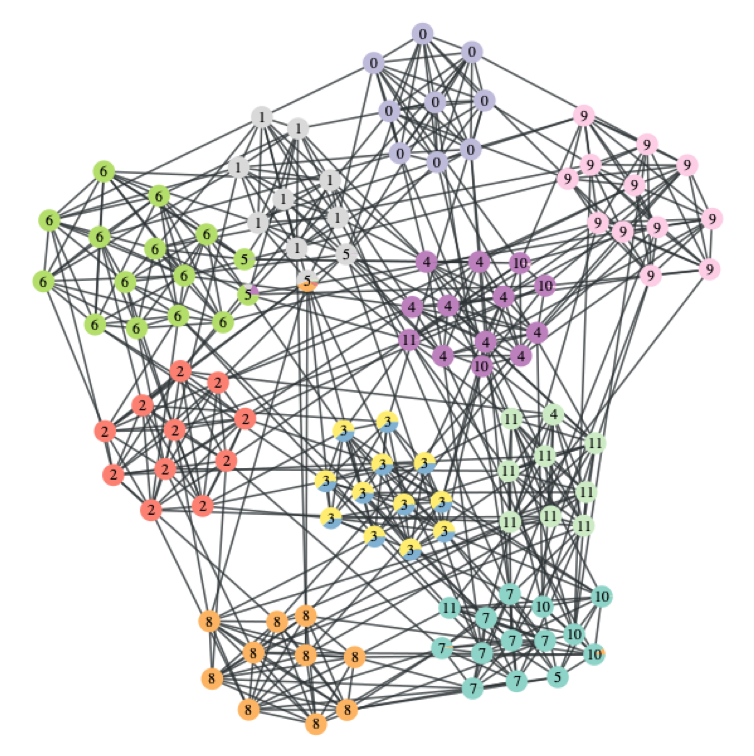

### Now we have a visualization of the community distrubution simulated by MCMC algorithm, nodes are colored as a pie, each fraction corresponding to the possibility of belong to a certain community. Numbers on the nodes correspond to the true community belonging (ground-truth), it can be seen that our  SBM model performs well as for recoverying the metadata and can be reasonable to make prediction to some extent.

In [4]:
#obtain a marginal probability of the number of groups itself, as follows.
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):        
        B = sl.get_nonempty_B()
        h[l][B] += 1

# Now we collect the marginal distribution for exactly 100,000 sweeps
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_num_groups)

(1745.183698985517, 13636492, 7393723)

In [5]:
state_0.draw(pos=g.vp.pos, vertex_shape="pie", vertex_pie_fractions=pv[0],vertex_text=vvertex, 
             edge_gradient=None, output="football-sbm-marginals.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x11ede9a90, at 0x1229ffb10>

### For more complecated networks, one can select the SBM model (degree-corrected or non degree-corrected) by following commands: 
#### (generally dcSBM is outperform the ndcSBM but there are exceptions such as this football network)

In [6]:
nL = 10

for deg_corr in [True, False]:
    state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)  
    
    bs = state.get_bs()                     # Get hierarchical partition.
    bs += [np.zeros(1)] * (nL - len(bs))    # Augment it to L = 10 with
                                            # single-group levels.

    state = state.copy(bs=bs, sampling=True)

    dls = []                               # description length history
    vm = [None] * len(state.get_levels())  # vertex marginals
    em = None                              # edge marginals

    def collect_marginals(s):
        global vm, em
        levels = s.get_levels()
        vm = [sl.collect_vertex_marginals(vm[l]) for l, sl in enumerate(levels)]
        em = levels[0].collect_edge_marginals(em)
        dls.append(s.entropy())

    # Now we collect the marginal distributions for exactly 200,000 sweeps
    gt.mcmc_equilibrate(state, force_niter=20000, mcmc_args=dict(niter=10),
                        callback=collect_marginals)

    S_mf = [gt.mf_entropy(sl.g, vm[l]) for l, sl in enumerate(state.get_levels())]
    S_bethe = gt.bethe_entropy(g, em)[0]
    L = -np.mean(dls)

    print("Model evidence for deg_corr = %s:" % deg_corr,
          L + sum(S_mf), "(mean field),", L + S_bethe + sum(S_mf[1:]), "(Bethe)")
   #Bethe approximation yields smaller values than the mean
   #field one and is generally considered to be superior.
    
#model with larger value of "model confidence" is preferred

Model evidence for deg_corr = True: -1632.3124207947992 (mean field), -1698.8660619888649 (Bethe)
Model evidence for deg_corr = False: -1651.1821643145408 (mean field), -1681.855633537675 (Bethe)


## next we try L=12:

In [10]:
import graph_tool.all as gt
import numpy as np

#Here we perform the sampling of hierarchical partitions using the same network as above.
#starting from an approximation of community structure, here we use the results given by the nested SBM fit
g = gt.collection.data["football"]
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)  

#state = gt.minimize_nested_blockmodel_dl(g) # Initialize he Markov
                                            # chain from the "ground
                                            # state"

# Before doing model averaging, the need to create a NestedBlockState
# by passing sampling = True.

# We also want to increase the maximum hierarchy depth to L = 10
#####try L =12 later
# We can do both of the above by copying.

bs = state.get_bs()                     # Get hierarchical partition.
bs += [np.zeros(1)] * (12 - len(bs))    # Augment it to L = 12 with
                                        # single-group levels.

state = state.copy(bs=bs, sampling=True)

# Now we run 1000 sweeps of the MCMC
#description length of the network measures the amount of information required to describe the data

dS, nattempts, nmoves = state.mcmc_sweep(niter=1000)

print("Change in description length, L=12:", dS)
print("Number of accepted vertex moves, L=12:", nmoves)

Change in description length, L=12: -3.4632662853384204
Number of accepted vertex moves, L=12: 73564


In [11]:
#FOR MODEL AVERAGING PROCESS (non nested model)
#obtain vertex marginals on all hierarchical levels:
#We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

pv = [None] * len(state.get_levels())

def collect_marginals(s):
    global pv
    pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

# Now we collect the marginals for exactly 100,000 sweeps
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_marginals)

# Now the node marginals for all levels are stored in property map
# list pv. We can visualize the first level as pie charts on the nodes:
vvertex = g.vertex_properties["value"]
state_0 = state.get_levels()[0]
state_0.draw(pos=g.vp.pos, vertex_shape="pie", vertex_pie_fractions=pv[0],vertex_text=vvertex, 
             edge_gradient=None, output="football-sbm-marginalsL12.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x145a72c10, at 0x145b675d0>

In [12]:
nL = 12

for deg_corr in [True, False]:
    state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)  
    
    bs = state.get_bs()                     # Get hierarchical partition.
    bs += [np.zeros(1)] * (nL - len(bs))    # Augment it to L = 10 with
                                            # single-group levels.

    state = state.copy(bs=bs, sampling=True)

    dls = []                               # description length history
    vm = [None] * len(state.get_levels())  # vertex marginals
    em = None                              # edge marginals

    def collect_marginals(s):
        global vm, em
        levels = s.get_levels()
        vm = [sl.collect_vertex_marginals(vm[l]) for l, sl in enumerate(levels)]
        em = levels[0].collect_edge_marginals(em)
        dls.append(s.entropy())

    # Now we collect the marginal distributions for exactly 200,000 sweeps
    gt.mcmc_equilibrate(state, force_niter=20000, mcmc_args=dict(niter=10),
                        callback=collect_marginals)

    S_mf = [gt.mf_entropy(sl.g, vm[l]) for l, sl in enumerate(state.get_levels())]
    S_bethe = gt.bethe_entropy(g, em)[0]
    L = -np.mean(dls)

    print("Model evidence for deg_corr = %s:" % deg_corr,
          L + sum(S_mf), "(mean field),", L + S_bethe + sum(S_mf[1:]), "(Bethe)")
   #Bethe approximation yields smaller values than the mean
   #field one and is generally considered to be superior.
    
#model with larger value of "model confidence" is preferred

Model evidence for deg_corr = True: -1644.6663557576217 (mean field), -1670.0277269980684 (Bethe)
Model evidence for deg_corr = False: -1635.802850456176 (mean field), -1695.145479063771 (Bethe)
